In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [36]:
def scorefunc(x, A,a,b,t):
    s1 = torch.matmul(x, A)
    score = -s1 + a*t**(-0.5) *torch.exp(-b*t) * x*(x**2-1)
    return score

In [37]:
def gen_noisy_data(x0,step,temp,dt,device = "cpu"):
    x0 = x0.to(device)
    step = step.to(device)
    noise = torch.randn_like(x0).to(device)
    exp_t =torch.exp(-dt*(step+1)).view(-1, 1)
    std_t = torch.sqrt(temp*(1-exp_t*exp_t))
    noisy_data = x0*exp_t + noise*std_t
    return noisy_data, -noise/std_t

In [38]:
L = 8
N = L**2
temp = 2.320

MCS = 200000
P = 100000

T = 1

nSteps = 300
dt = 0.02

data = load_data(L,temp,MCS)
data = torch.from_numpy(data).to(torch.float32)

In [39]:
device = "cuda"
500*256/P

1.28

In [44]:
A = torch.randn((nSteps,N,N))/N**0.5
A = A.to(device).requires_grad_(True)

#g = torch.randn((nSteps,1))/N**0.5
tau = torch.randn((nSteps,1))/N**0.5
g0 = torch.randn((nSteps,1))/N**0.5
#g = g.to(device).requires_grad_(True)
tau = tau.to(device).requires_grad_(True)
g0 = g0.to(device).requires_grad_(True)
n_epochs = 500
batch_size = 512
learning_rate = 0.1
optimizer = torch.optim.Adam([A,tau,g0],lr = learning_rate)
decay_rate = 1-np.log(10)/n_epochs
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
myloss = torch.nn.MSELoss().to(device)


In [45]:
for epochs in range(n_epochs):
    idx = np.random.choice(range(P),batch_size,replace =False)
    loss=0
    for tt in range(nSteps):
        tnow = torch.Tensor([[tt+1,]]).to("cuda")
        x_train,y_train = gen_noisy_data(data[idx],tnow,T,dt,device)
        loss += myloss(scorefunc(x_train,A[tt],tau[tt],g0[tt],tnow*dt),y_train)/nSteps
        #loss += (myloss(scorefunc(x_train,A[tt],B[tt]),y_train))/nSteps 
    loss+= 0.0005* torch.sum(torch.abs(A))/nSteps
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if (epochs+1)%100 ==0:
        print(f"epoch = {epochs+1}, loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}")


epoch = 100, loss = 0.15588611364364624, lr = 0.06302865857645837
epoch = 200, loss = 0.1551966667175293, lr = 0.039726118019477646
epoch = 300, loss = 0.15382343530654907, lr = 0.02503883929217749
epoch = 400, loss = 0.15225985646247864, lr = 0.015781644528974674
epoch = 500, loss = 0.14903385937213898, lr = 0.009946958847917782


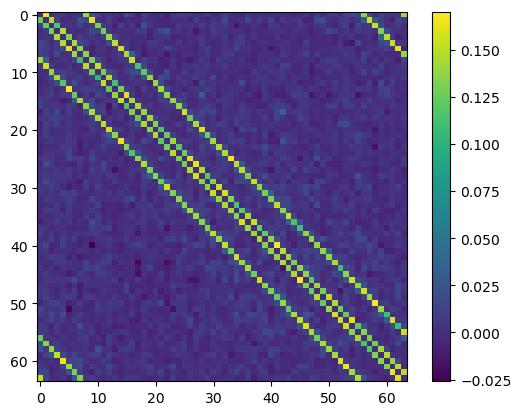

In [46]:
plt.imshow((-A[0].cpu().detach().numpy() + np.diag(np.diag(A[0].cpu().detach().numpy()))))
plt.colorbar()

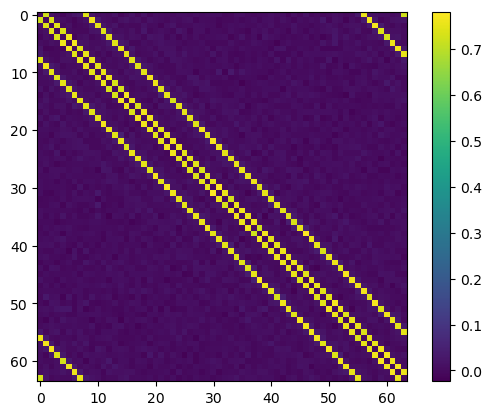

In [47]:
Jtrue = np.linalg.inv(np.cov(data.T))
plt.imshow(-Jtrue+np.diag(np.diag(Jtrue)) )
plt.colorbar()

In [54]:
def backward(xT,A,tau,g,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    with torch.no_grad():
        for tt in range(nSteps)[::-1]:
            std = np.sqrt(2*(temp)*dt)*torch.randn_like(xT)
            #den = np.sqrt(temp*(1-np.exp(-2*(tt+1))))
            if tt==0:
                std = torch.zeros(xT.shape)
            for n in range(nbatches):
                if(full_traj):
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt],tau[tt],g[tt],torch.Tensor([(tt+1)*dt,]).to(device))
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size], A[tt],tau[tt],g[tt],torch.Tensor([(tt+1)*dt,]).to(device))
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
        
    return x_recon

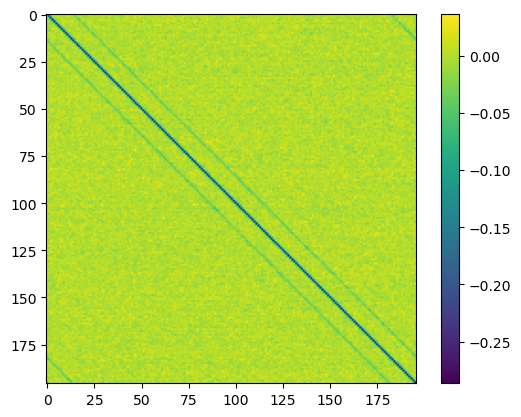

In [19]:
A_optim = A.cpu().detach()
G_optim = G.cpu().detach()
#plt.plot([*range(1,1+nSteps)],g_optim.numpy())
#plt.axvline(np.log(N))
#plt.xscale("log")
plt.imshow(G_optim[10])
plt.colorbar()

In [55]:
xT = np.sqrt(T)*torch.randn((P,N))
x_recon = backward(xT,A.cpu(),tau.cpu(),g0.cpu(),T,nSteps,dt).numpy()

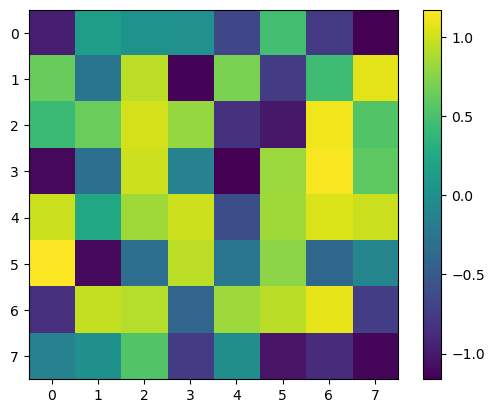

In [56]:
plt.imshow(x_recon[0].reshape(L,L))
plt.colorbar()

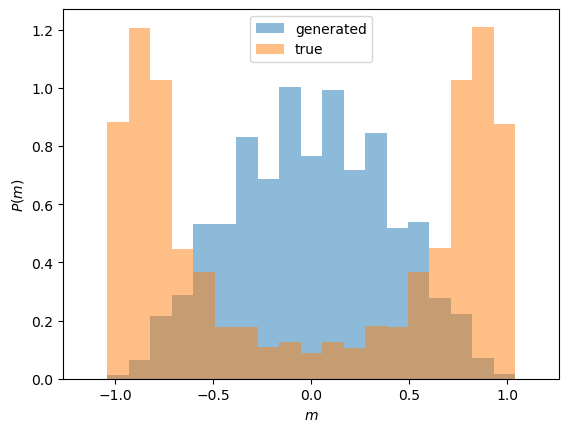

In [60]:
plt.hist(np.mean(np.sign(x_recon),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "generated")
plt.hist(np.mean(data.numpy(),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()

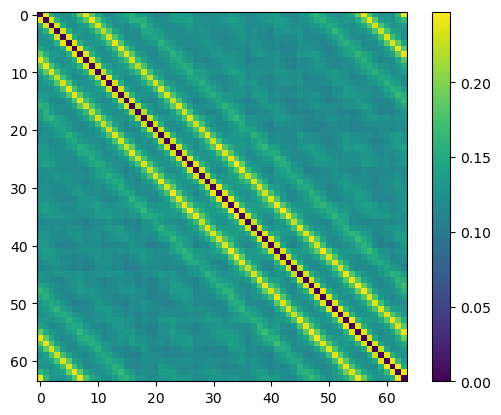

In [58]:
Jpred = np.cov(x_recon.T)
Jpred = Jpred - np.diag(np.diag(Jpred))
plt.imshow(Jpred)
plt.colorbar()

(array([11242.,  7793.,  5751.,  4670.,  4066.,  3558.,  3360.,  3096.,
         3062.,  3064.,  2975.,  3017.,  3140.,  3382.,  3655.,  4055.,
         4837.,  5953.,  7835., 11489.]),
 array([-1.21369839e+00, -1.09237778e+00, -9.71057177e-01, -8.49736512e-01,
        -7.28415906e-01, -6.07095301e-01, -4.85774696e-01, -3.64454061e-01,
        -2.43133456e-01, -1.21812835e-01, -4.92215157e-04,  1.20828405e-01,
         2.42149025e-01,  3.63469630e-01,  4.84790266e-01,  6.06110871e-01,
         7.27431476e-01,  8.48752081e-01,  9.70072746e-01,  1.09139335e+00,
         1.21271396e+00]),
 <BarContainer object of 20 artists>)

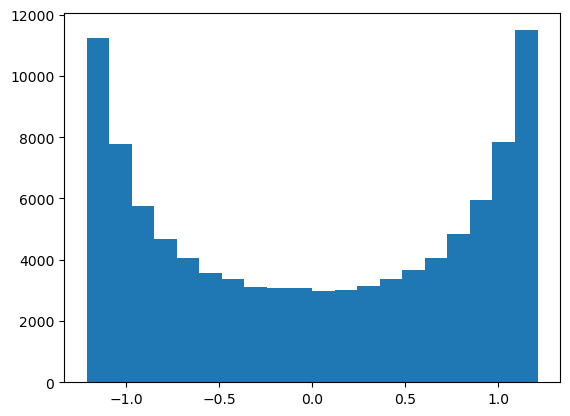

In [59]:
plt.hist(x_recon[:,10],bins = 20)